# Measure the density profile of a Dark Matter Halo

The Navarro–Frenk–White (NFW) profile is a spatial mass distribution of dark matter fitted to dark matter halos identified in N-body simulations by Julio Navarro, Carlos Frenk and Simon White (https://ui.adsabs.harvard.edu/abs/1996ApJ...462..563N/abstract). The NFW profile is one of the most commonly used model profiles for dark matter halos.

In the NFW profile, the density of dark matter as a function of radius is given by:

\begin{equation}
\rho (r)={\frac {\rho _{0}}{{\frac {r}{R_{s}}}\left(1~+~{\frac {r}{R_{s}}}\right)^{2}}}
\end{equation}

The integrated mass within some radius $R_{max}$ is

\begin{equation}
M=\int _{0}^{R_{\max }}4\pi r^{2}\rho (r)\,dr=4\pi \rho _{0}R_{s}^{3}\left[\ln \left({\frac {R_{s}+R_{\max }}{R_{s}}}\right)+{\frac {R_{s}}{R_{s}+R_{\max }}}-1\right]
\end{equation}

# 1 Simulate a Dark Matter Halo

How to sample particles according to a given density profile?

Inverse transform sampling

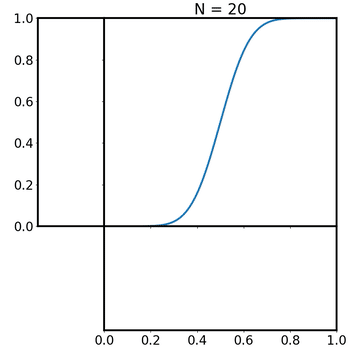

https://en.wikipedia.org/wiki/Inverse_transform_sampling

In [1]:
import numpy as np
import pylab as pl
from scipy import interpolate

#--------------------------------------------------------------------
def xy_rotate(x, y, xcen, ycen, phi):
    phirad = np.deg2rad(phi)
    xnew = (x-xcen)*np.cos(phirad)+(y-ycen)*np.sin(phirad)
    ynew = (y-ycen)*np.cos(phirad)-(x-xcen)*np.sin(phirad)
    return xnew+xcen,ynew+ycen

#--------------------------------------------------------------------
def rho_NFW(r, rho_0, R_s):
    # complete the function according to the equation above
    res = rho_0/((r/R_s)*(1 + r/R_s)**2)
    return res
#--------------------------------------------------------------------
def mass_rmax_NFW(R_max, rho_0, R_s):
    # complete the function according to the equation above
    res = 4*np.pi*rho_0*R_s**3*(np.log(1 + R_max/R_s) + 1/(1+R_max/R_s) - 1)
    return res
#--------------------------------------------------------------------
def invert_CDF_NFW(R_max, rho_0, R_s):
    rr = np.linspace(0.0, R_max, 1000)
    mm = mass_rmax_NFW(rr, rho_0, R_s)
    # build a function based on the arrays [mm, rr] with scipy.interpolate.interp1d
    res = interpolate.interp1d(mm, rr)
    return res
#--------------------------------------------------------------------
def sample_particles_R_NFW(num_Prtcls, R_max, rho_0, R_s):
    y_arr_01 = np.random.random(num_Prtcls)
    m_R_max = mass_rmax_NFW(R_max, rho_0, R_s)
    y_arr = m_R_max*y_arr_01
    func_tmp = invert_CDF_NFW(R_max, rho_0, R_s)
    # calculate R using the values above with for loop and list
    res = np.array([func_tmp(y_i) for y_i in y_arr])
    return res
#--------------------------------------------------------------------
def sample_particles_XYZ_NFW(num_prtcls, R_max, rho_0, R_s, xcen=0.0, ycen=0.0, zcen=0.0, qsqrt=1.0, pa=37):
    ra = sample_particles_R_NFW(num_prtcls, R_max, rho_0, R_s)
    theta = np.arccos(np.random.random_sample(num_prtcls)*2.0-1.0)
    psi = 2.0*np.pi*np.random.random_sample(num_prtcls)
    rx = ra*np.sin(theta)*np.cos(psi)/qsqrt + xcen
    ry = ra*np.sin(theta)*np.sin(psi)*qsqrt + ycen
    rz = ra*np.cos(theta) + zcen
    rxr, ryr = xy_rotate(rx,ry,xcen,ycen,pa)
    rzr = rz
    return rxr, ryr, rzr

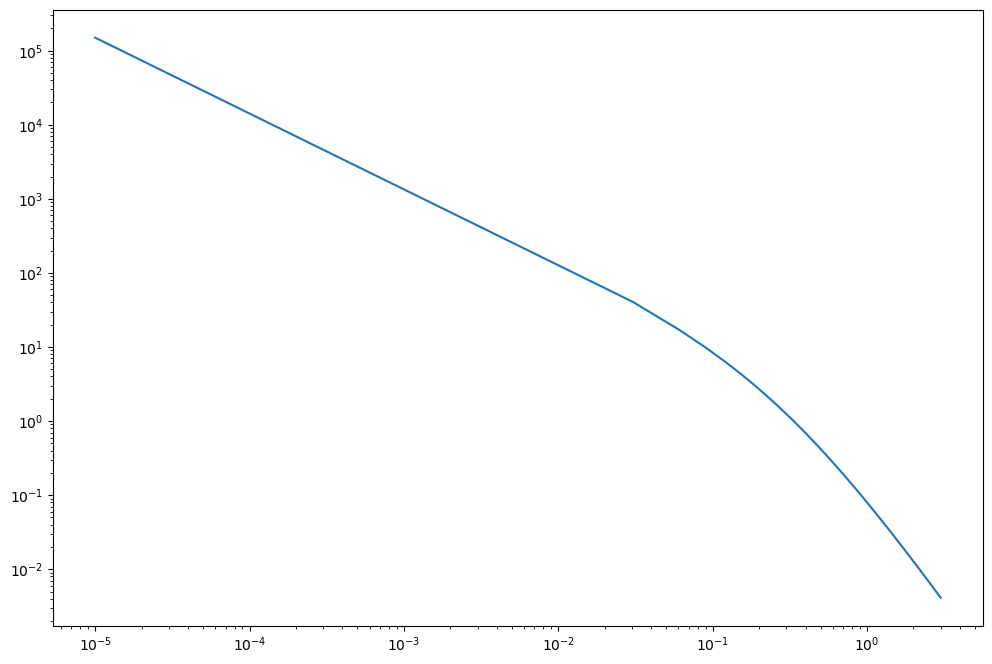

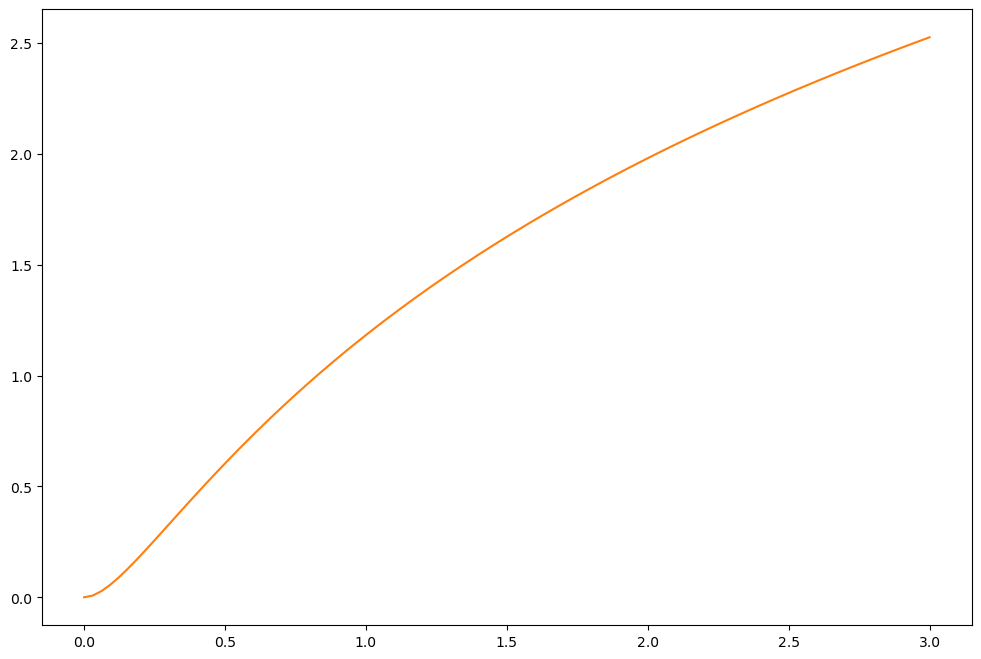

In [2]:
# visualize the functions you created

R_max_0 = 3.0
R_s_0 = 0.3
rho_0_0 = 5.0

nbins = 100
rbins = np.linspace(1e-5, R_max_0, nbins)

# complete the code below
pl.figure(figsize=(12, 8))
pl.loglog(rbins, rho_NFW(rbins, rho_0_0, R_s_0), 'C0-', label='NFW Density Profile')

pl.figure(figsize=(12, 8))
pl.plot(rbins, mass_rmax_NFW(rbins, rho_0_0, R_s_0), 'C1-', label='NFW Enclosed-mass Model')

(-5.0, 5.0)

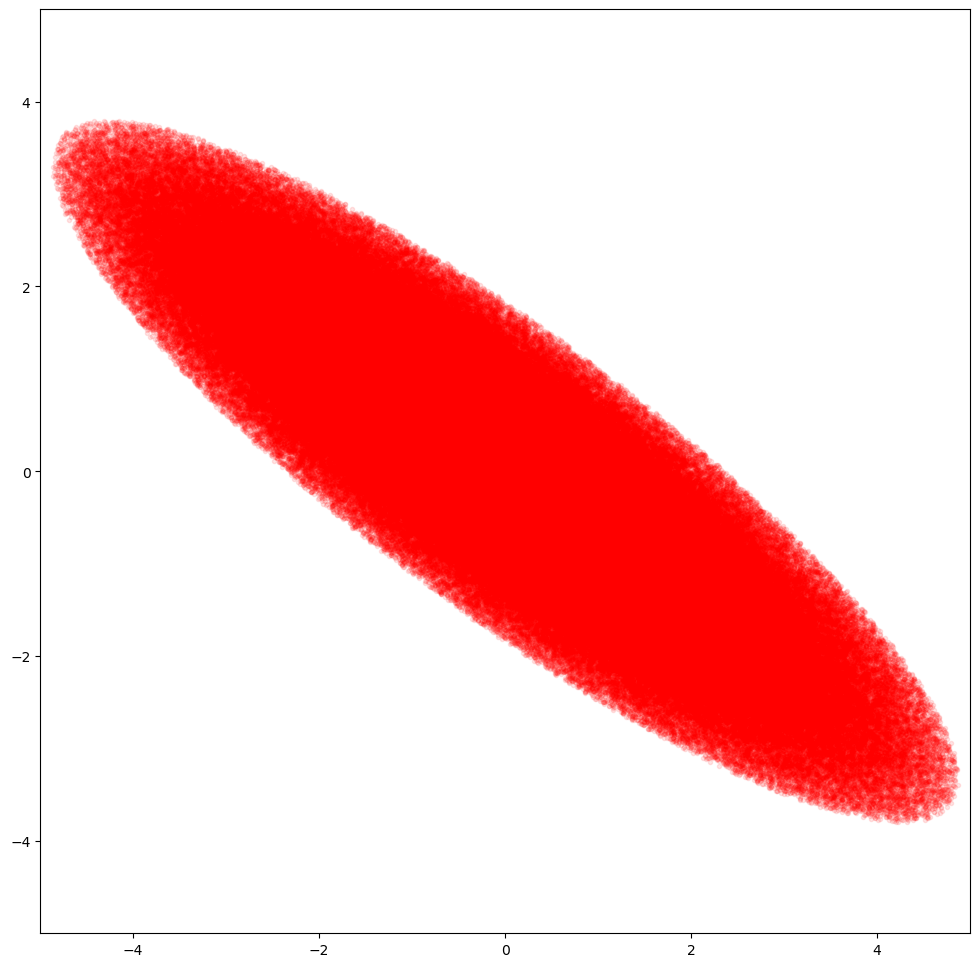

In [3]:
nPrtcls = 1000000
mPrtcls = mass_rmax_NFW(R_max_0, rho_0_0, R_s_0)/nPrtcls

# complete the code below
xt, yt, zt = sample_particles_XYZ_NFW(nPrtcls, R_max_0, rho_0_0, R_s_0, qsqrt=0.5)
rt = np.sqrt(xt*xt + yt*yt + zt*zt) # calculate radii of particles

# visualize the simulated halo
pl.figure(figsize=(12, 12))
pl.plot(xt, yt, 'r.', alpha=0.1) # try different alpha values
pl.xlim(-5, 5)
pl.ylim(-5, 5)

# 2 Fit the data to the NFW profile
## 2.1 Fit to NFW density profile

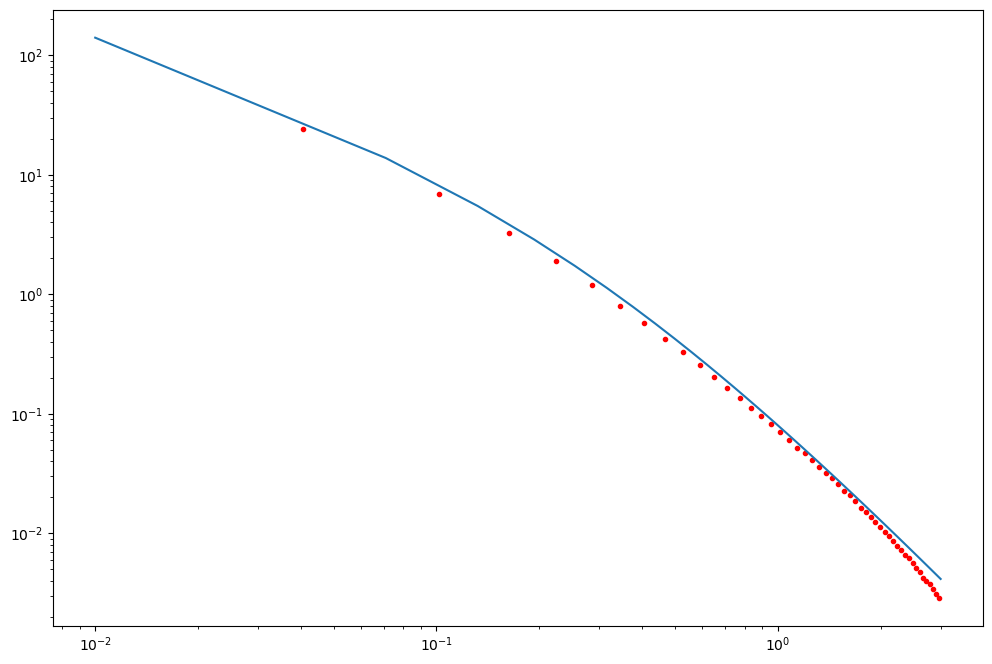

In [4]:
# In linear space

nbins = 50
rbins = np.linspace(1e-2, R_max_0, nbins)

rb = []
yb = []
eb = []
for i in range(nbins-1):
    idx1 = rt > rbins[i]
    idx2 = rt <= rbins[i+1]
    idx = idx1&idx2
    rb_tmp = (rbins[i+1] + rbins[i])*0.5
    dr_tmp = (rbins[i+1] - rbins[i])
    # how to calculate density profile within the bin above?
    yb_tmp = len(rt[idx])*mPrtcls/(4.0*np.pi*rb_tmp**2.0*dr_tmp)
    rb.append(rb_tmp)
    yb.append(yb_tmp)
    eb.append(np.sqrt(len(rt[idx]))) # what is this?
    
pl.figure(figsize=(12, 8))
pl.loglog(rb, yb, 'r.') 
pl.loglog(rbins, rho_NFW(rbins, rho_0_0, R_s_0), '-')

In [5]:
from scipy.optimize import curve_fit

# # complete the code below
# popt, pcov = curve_fit(rho_NFW, rb, yb)#, sigma=eb)

# print(popt)

# pl.figure(figsize=(12, 8))
# pl.plot(rb, yb, 'C0.') 
# pl.plot(rbins, rho_NFW(rbins, rho_0_0, R_s_0), 'C1-', label='True Model')
# pl.plot(rb, rho_NFW(rb, *popt), 'C2-',
#          label=r'fit: $\rho_0=%5.3f, R_s=%5.3f$' % tuple(popt))
# pl.xlim(0.01, R_max_0)
# pl.ylim(1e-3, 1e3)
# pl.legend()

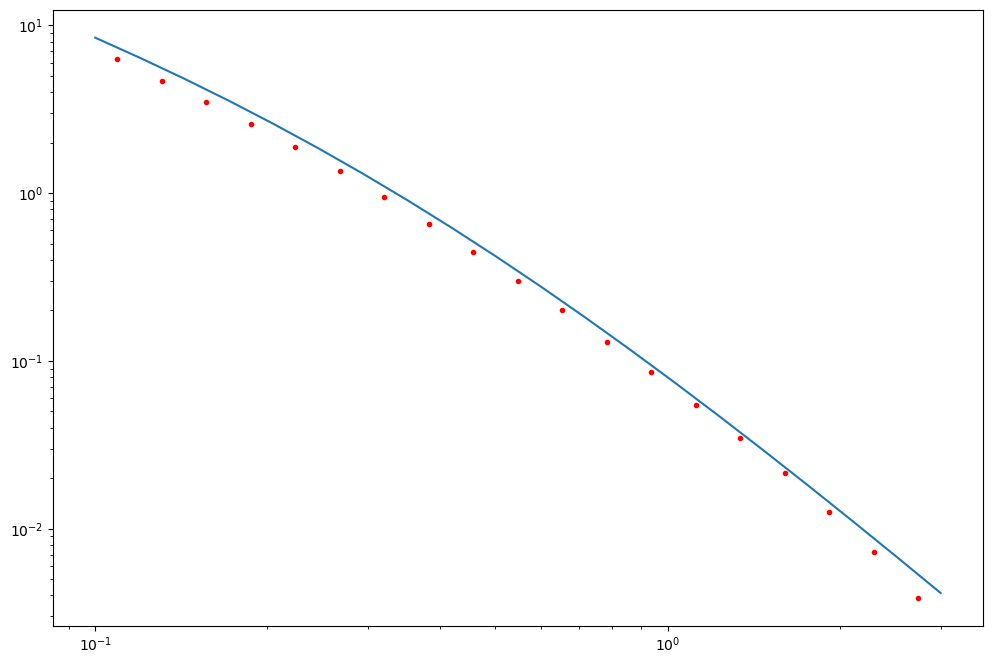

In [6]:
# In logarithm space

nbins = 20

# build logarithm bins
rbins = np.logspace(-1, np.log10(R_max_0), nbins)

rb = []
yb = []
eb = []
for i in range(nbins-1):
    idx1 = rt > rbins[i]
    idx2 = rt <= rbins[i+1]
    idx = idx1&idx2
    # how to calcuate centers of bins in logarithm space?
    rb_tmp = 10**((np.log10(rbins[i+1]) + np.log10(rbins[i]))*0.5)
    dr_tmp = (rbins[i+1] - rbins[i])
    # how to calculate yb?
    yb_tmp = len(rt[idx])*mPrtcls/(4.0*np.pi*rb_tmp**2.0*dr_tmp)
    rb.append(rb_tmp)
    yb.append(yb_tmp)
    eb.append(np.sqrt(len(rt[idx])/nPrtcls)/10)

rb_arr = np.array(rb)
yb_arr = np.array(yb)
eb_arr = np.array(eb)

pl.figure(figsize=(12, 8))
pl.loglog(rb, yb, 'r.') 
pl.loglog(rbins, rho_NFW(rbins, rho_0_0, R_s_0), '-')

/var/folders/7z/hdr_2hpx1td2cw2cxslg7d1w0000gs/T/ipykernel_89453/40902300.py:7: RuntimeWarning: invalid value encountered in log10
  return np.log10(res)


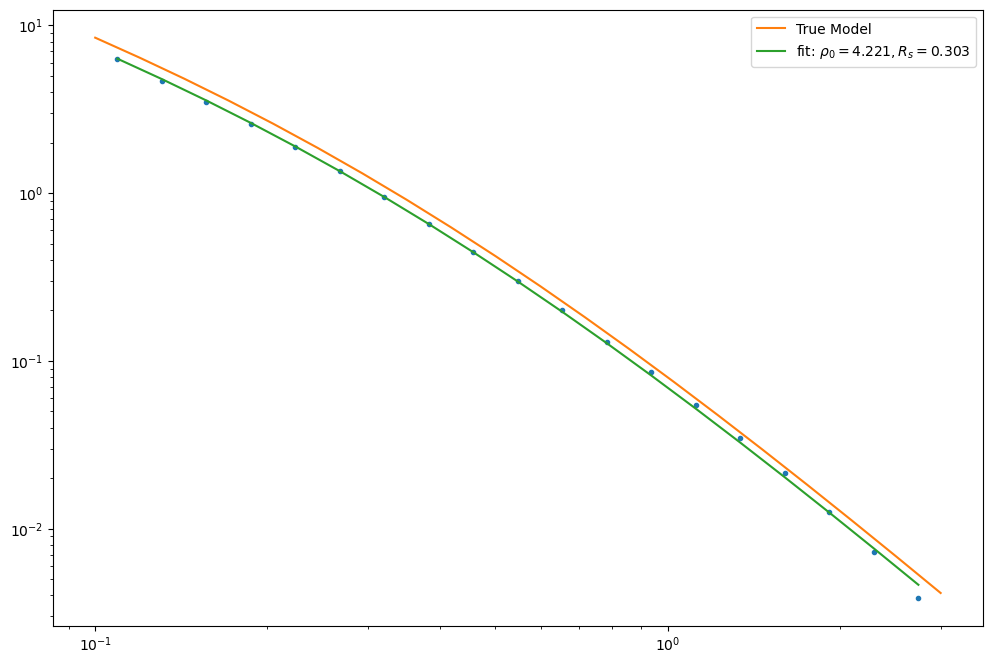

In [9]:
from scipy.optimize import curve_fit

def log_rho_NFW(log_r, rho_0, R_s):
    r = 10**log_r
    # define rho_NFW in logarithm space
    res = rho_0/((r/R_s)*(1 + r/R_s)**2)
    return np.log10(res)

log_rb_arr = np.log10(rb_arr)
log_yb_arr = np.log10(yb_arr)
log_eb_arr = np.log10(eb_arr)/50.0

idx_inf = np.isinf(log_yb_arr) # remove infs, think of how to remove NaNs?
popt, pcov = curve_fit(log_rho_NFW, log_rb_arr[~idx_inf], log_yb_arr[~idx_inf])#, sigma=eb)

pl.figure(figsize=(12, 8))
pl.loglog(rb, yb, 'C0.') 
pl.loglog(rbins, rho_NFW(rbins, rho_0_0, R_s_0), 'C1-', label='True Model')
pl.loglog(rb, rho_NFW(rb, *popt), 'C2-',
         label=r'fit: $\rho_0=%5.3f, R_s=%5.3f$' % tuple(popt))
pl.legend()

## 2.2 Fit to NFW mass model

In [10]:
# nbins = 100
# rbins = np.linspace(1e-2, R_max_0, nbins)

# rb = []
# yb = []
# eb = []
# for i in range(nbins-1):
#     idx = rt<rbins[i+1]
#     rb_tmp = rbins[i+1]
#     # how to calculate yb_tmp here?
#     yb_tmp = len(rt[idx])*mPrtcls
#     rb.append(rb_tmp)
#     yb.append(yb_tmp)
#     eb.append(np.sqrt(len(rt[idx])/nPrtcls)/10)
    
# rb_arr = np.array(rb)
# yb_arr = np.array(yb)
# eb_arr = np.array(eb)


# pl.figure(figsize=(12, 8))
# pl.loglog(rb, yb, 'r.') 
# pl.loglog(rbins, mass_rmax_NFW(rbins, rho_0_0, R_s_0), '-')

In [11]:
# from scipy.optimize import curve_fit

# # complete the code below
# popt, pcov = curve_fit(mass_rmax_NFW, rb, yb) #, sigma=eb)

# print(popt)
# print(pcov)

# pl.figure(figsize=(12, 8))
# pl.loglog(rb, yb, 'C0.') 
# pl.loglog(rbins, mass_rmax_NFW(rbins, rho_0_0, R_s_0), 'C1-', label='True Model')
# pl.loglog(rb, mass_rmax_NFW(rb, *popt), 'C2-',
#          label=r'fit: $\rho_0=%5.3f, R_s=%5.3f$' % tuple(popt))
# pl.legend()

/var/folders/7z/hdr_2hpx1td2cw2cxslg7d1w0000gs/T/ipykernel_89453/40902300.py:7: RuntimeWarning: invalid value encountered in log10
  return np.log10(res)
/var/folders/7z/hdr_2hpx1td2cw2cxslg7d1w0000gs/T/ipykernel_89453/40902300.py:7: RuntimeWarning: invalid value encountered in log10
  return np.log10(res)
/var/folders/7z/hdr_2hpx1td2cw2cxslg7d1w0000gs/T/ipykernel_89453/40902300.py:7: RuntimeWarning: invalid value encountered in log10
  return np.log10(res)
/var/folders/7z/hdr_2hpx1td2cw2cxslg7d1w0000gs/T/ipykernel_89453/40902300.py:7: RuntimeWarning: invalid value encountered in log10
  return np.log10(res)


Maximum likelihood estimates:
Rho_0 = 5.007
R_s = 0.337
4.89498059070405 0.3181854673436006
5.0 0.3


ValueError: 'yerr' must not contain negative values

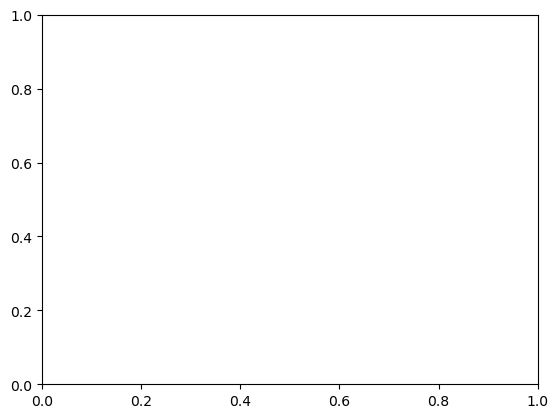

In [12]:
from scipy.optimize import minimize

def least_square(theta, x, y, yerr):
    rho_0_f, R_s_f = theta
    # model = mass_rmax_NFW(x, rho_0_f, R_s_f)
    # model = rho_NFW(x, rho_0_f, R_s_f)
    model = log_rho_NFW(x, rho_0_f, R_s_f)
    sigma = yerr ** 2
    return np.sum((y - model) ** 2 / sigma)

nll = lambda *args: least_square(*args)
initial = np.array([rho_0_0, R_s_0]) + 0.1 * np.random.randn(2)
soln_ls = minimize(nll, initial, args=(log_rb_arr, log_yb_arr, log_eb_arr))
rho_0_ls, R_s_ls = soln_ls.x

def log_likelihood(theta, x, y, yerr):
    rho_0_f, R_s_f  = theta
    # model = mass_rmax_NFW(x, rho_0_f, R_s_f)
    # model = rho_NFW(x, rho_0_f, R_s_f)
    model = log_rho_NFW(x, rho_0_f, R_s_f)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

#max log_likelihood
nll = lambda *args: -log_likelihood(*args)
initial = np.array([rho_0_0, R_s_0]) + 0.1 * np.random.randn(2)
soln_ml = minimize(nll, initial, args=(log_rb_arr, log_yb_arr, log_eb_arr))
rho_0_ml, R_s_ml = soln_ml.x

print("Maximum likelihood estimates:")
print("Rho_0 = {0:.3f}".format(rho_0_ml))
print("R_s = {0:.3f}".format(R_s_ml))

print(rho_0_ls, R_s_ls)
print(rho_0_0, R_s_0)


#make the plot
pl.errorbar(log_rb_arr, log_yb_arr, yerr=log_eb_arr, fmt=".b", capsize=0)
# pl.plot(np.log10(rb_arr), np.log10(mass_rmax_NFW(rb_arr, rho_0_0, R_s_0)), "k-", alpha=0.3, lw=5, label="truth")
pl.plot(log_rb_arr, log_rho_NFW(log_rb_arr, rho_0_0, R_s_0), "k-", alpha=0.3, lw=5, label="truth")
# pl.plot(rb_arr, np.dot(np.vander(rb_arr, 2), [rho_0_ls, R_s_ls]), "--k", label="LS")
# pl.plot(rb_arr, np.dot(np.vander(rb_arr, 2), [rho_0_ml, R_s_ml]), ":k", label="ML")
pl.legend(fontsize=14)
pl.xlim(-3, 2)
pl.xlabel("x")
pl.ylabel("y");

In [13]:
def log_prior(theta):
    rho_0_f, R_s = theta
    if 3 < rho_0_f < 7 and 0.1 < R_s < 0.5:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

import emcee

nsteps = 5000

pos = soln_ml.x +  0.01*np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(log_rb_arr, log_yb_arr, log_eb_arr)
)
sampler.run_mcmc(pos, nsteps, progress=True);

100%|█████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2381.13it/s]


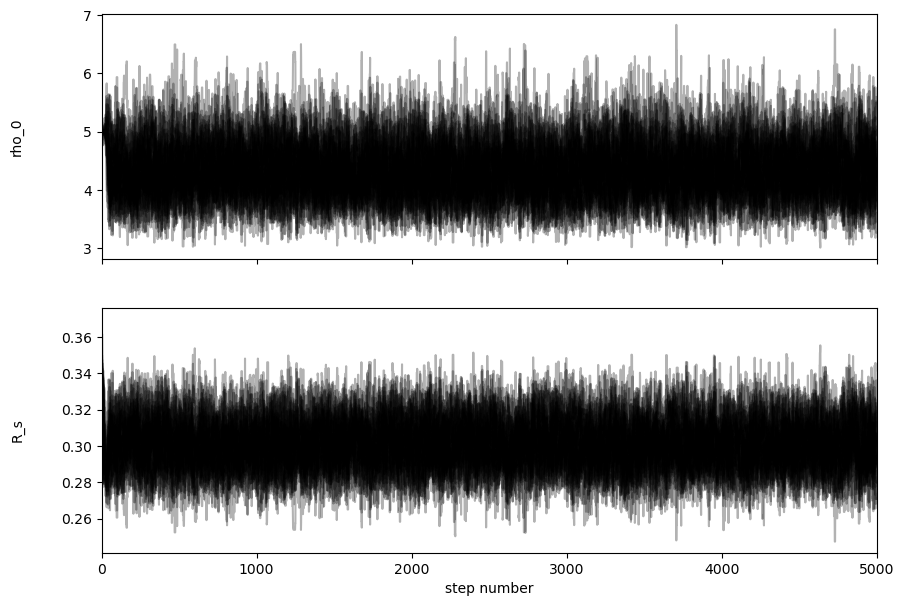

In [14]:
fig, axes = pl.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["rho_0", "R_s"]

samples=samples[:, :, :]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [15]:
tau = sampler.get_autocorr_time()
print(tau)

[35.57404583 35.08820523]


In [16]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
flat_samples_2 = sampler.get_chain(discard=1000, thin=2, flat=True)
print(samples.shape)
print(flat_samples.shape)
print(flat_samples_2.shape)

(5000, 32, 2)
(8512, 2)
(64000, 2)


2.0441363765709117 2.0446497488412243


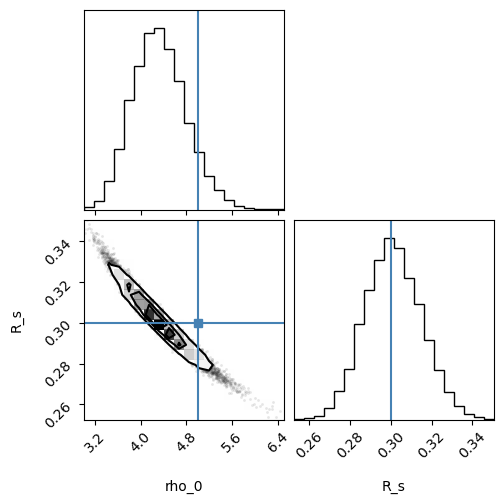

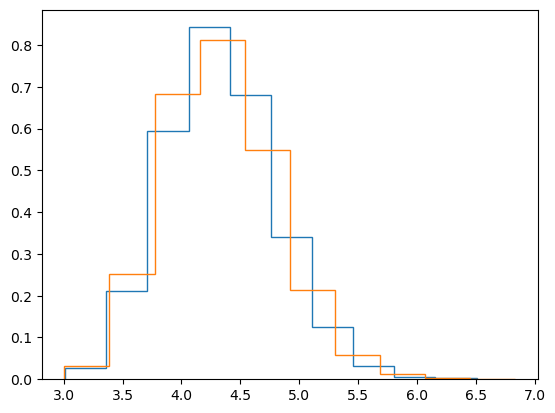

In [17]:
import corner
fig = corner.corner(
    flat_samples, labels=labels, truths=[rho_0_0, R_s_0]
)

pl.figure()
pl.hist(flat_samples[:,0],histtype='step',density=True)
pl.hist(flat_samples_2[:,0],histtype='step',density=True)
print(flat_samples.std(),flat_samples_2.std())

## 口头报告

基于大作业内容完成一个口头报告，报告内容应包括：

- 1. 学生所做大作业介绍（逻辑严谨、流畅、完整）
	- a. 工作动机
	- b. 工作内容
	- c．结果、讨论、结论
- 2. 通过完成这个工作你学到了什么？
- 3. 未来的工作方向和展望（计划的传承性、展望的创新性）

